<a href="https://colab.research.google.com/github/Jenny023/Decision-Tree-Classifier-for-SNLI/blob/main/LoLa_DT_JB_AP_AL_GIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logic & Language: SNLI Decision Tree Classifier

Originally by Lasha.Abzianidze@gmail.com

Edited by Jenifer Batchelor, Anne Leendertse and Aniek Peters




# Decision trees on SNLI

The following code demonstrates how to load and process the SNLI dataset using the snli_jsonl2dict function. This function efficiently extracts data by separating NLI problem information from sentence annotations, since many sentences appear in multiple NLI problems. By avoiding redundant processing, this approach saves both memory and computation time, which is crucial when handling 550K NLI problems.

To facilitate feature extraction, the following functions are provided in this notebook:



*   sen2features: Extracts features at the sentence level.
*   problem2features: Extracts features at the NLI problem level.
*   probs2df: Converts extracted features into a structured DataFrame for further analysis.

In [ ]:
from tqdm import tqdm
import pandas as pd

In [ ]:
# assigntools package is a course specific collection of useful tools
!rm -fr assigntools # helps to rerun this cell witthout errors, if recloning needed
! git clone https://github.com/kovvalsky/assigntools.git

Cloning into 'assigntools'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 259 (delta 25), reused 7 (delta 3), pack-reused 200 (from 1)
Receiving objects: 100% (259/259), 63.63 KiB | 2.65 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [ ]:
from assigntools.LoLa.read_nli import snli_jsonl2dict, sen2anno_from_nli_problems
from assigntools.LoLa.sen_analysis import spacy_process_sen2tok, display_doc_dep

## Reading data

In [ ]:
from nltk.tree import Tree

In [ ]:
# Get SNLI data on fly
!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip
!unzip snli_1.0.zip
# !rm -r __MACOSX/ snli_1.0/*_test*

--2025-02-12 10:44:56--  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94550081 (90M) [application/zip]
Saving to: ‘snli_1.0.zip’

snli_1.0.zip        100%[===================>]  90.17M  5.76MB/s    in 16s     

2025-02-12 10:45:12 (5.80 MB/s) - ‘snli_1.0.zip’ saved [94550081/94550081]

Archive:  snli_1.0.zip
   creating: snli_1.0/
  inflating: snli_1.0/.DS_Store      
   creating: __MACOSX/
   creating: __MACOSX/snli_1.0/
  inflating: __MACOSX/snli_1.0/._.DS_Store  
 extracting: snli_1.0/Icon           
  inflating: __MACOSX/snli_1.0/._Icon  
  inflating: snli_1.0/README.txt     
  inflating: __MACOSX/snli_1.0/._README.txt  
  inflating: snli_1.0/snli_1.0_dev.jsonl  
  inflating: snli_1.0/snli_1.0_dev.txt  
  inflating: snli_1.0/snli_1.0_test.jsonl  
  inflating: snli_1.0/snli_1.0_

In [ ]:
# takes ~1min to read and pre-process data
# By default it reads the problems that have a gold label.
# SNLI is dict {part: {problem_id: problem_info}}
# S2A is dict {sentence: sentence annotation dict}
SNLI, S2A = snli_jsonl2dict('snli_1.0')

Found .json files for ['dev', 'train', 'test'] parts
processing DEV:	

10000it [00:01, 9842.32it/s]


158 problems without a gold label were ignored
0 problems have a wrong annotator label
9842 problems were returned
processing TRAIN:	

550152it [00:44, 12297.76it/s]


785 problems without a gold label were ignored
198 problems have a wrong annotator label
549169 problems were returned
processing TEST:	

10000it [00:00, 17765.37it/s]

176 problems without a gold label were ignored
0 problems have a wrong annotator label
9824 problems were returned


In [ ]:
# access a problem with its ID in the train part
some_prob = SNLI['train']['4804607632.jpg#0r1e']
display(some_prob) # you can use print but the data will be squeezed in a single line

{'g': 'neutral',
 'pid': '4804607632.jpg#0r1e',
 'cid': '4804607632.jpg#0',
 'lnum': 5,
 'lcnt': Counter({'entailment': 2, 'neutral': 3}),
 'ltype': '230',
 'p': 'An older man sits with his orange juice at a small table in a coffee shop while employees in bright colored shirts smile in the background.',
 'h': 'An elderly man sits in a small shop.'}

In [ ]:
# The analysis/annotation of the hypothesis sentence
# It includes tokenization, tree structures and pos tags.
# Additionally, for each sentence you can find out in which
# parts, problems, and role (premise or hypothesis) it occurs.
# Check the key "pids" (problemIDs) for this info.
print(f"Sentence: {some_prob['h']}")
S2A[some_prob['h']]

Sentence: An elderly man sits in a small shop.


{'tree': '(ROOT (S (NP (DT An) (JJ elderly) (NN man)) (VP (VBZ sits) (PP (IN in) (NP (DT a) (JJ small) (NN shop)))) (. .)))',
 'btree': '( ( An ( elderly man ) ) ( ( sits ( in ( a ( small shop ) ) ) ) . ) )',
 'tok': ['An', 'elderly', 'man', 'sits', 'in', 'a', 'small', 'shop', '.'],
 'pos': ['DT', 'JJ', 'NN', 'VBZ', 'IN', 'DT', 'JJ', 'NN', '.'],
 'pids': {('train', '4804607632.jpg#0r1e', 'h')}}

In [ ]:
# It is a good idea to keep the problem annotations and sentence annotations separately
# because many sentences occur in many NLI problems and you don't want to extract features
# for the same sentence for each problem it occurs in.
# For example the following sentence occurs many times in NLI problems
len(S2A["A man is sleeping."]['pids'])

343

### Displaying syntax trees

In [ ]:
# we can read tree representations as NLTK Tree objects
t = Tree.fromstring(S2A[some_prob['h']]['tree'])
print(t)
# better printing
t.pretty_print()

(ROOT
  (S
    (NP (DT An) (JJ elderly) (NN man))
    (VP (VBZ sits) (PP (IN in) (NP (DT a) (JJ small) (NN shop))))
    (. .)))
                     ROOT                       
                      |                          
                      S                         
        ______________|_______________________   
       |                   VP                 | 
       |          _________|___               |  
       |         |             PP             | 
       |         |     ________|____          |  
       NP        |    |             NP        | 
  _____|_____    |    |     ________|____     |  
 DT    JJ    NN VBZ   IN   DT       JJ   NN   . 
 |     |     |   |    |    |        |    |    |  
 An elderly man sits  in   a      small shop  . 



In [ ]:
# you need to have svgline installed to display tree objects
! pip install svgling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.2 MB/s eta 0:00:00


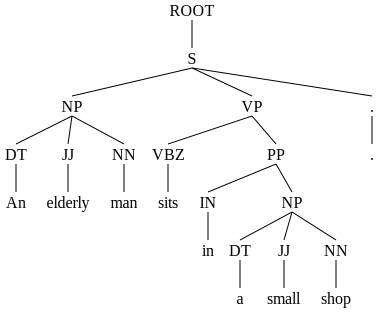

In [ ]:
# display tree
t

### Datasplit

In [ ]:
# Separate training instances labeled by 5 annotators
labeled_5 = {pid: ex for pid, ex in SNLI['train'].items() if ex['lnum'] == 5}

# Take the first 10,000 instances as the pre-development set
SNLI['dev_set_new'] = {pid: labeled_5[pid] for pid in sorted(labeled_5)[:10000]}

# Remaining training data: everything in 'train' except the dev set
SNLI['sub_train2'] = {pid: ex for pid, ex in SNLI['train'].items() if pid not in SNLI['dev_set_new']}

# Final training set used for analysis: first 200,000 of sub_train2
SNLI['sub_train3'] = { pid: SNLI['sub_train2'][pid] for pid in sorted(SNLI['sub_train2'])[:200000] }

In [ ]:
# Print the sizes of the datasets
print(f"Total training examples in SNLI['train']: {len(SNLI['train'])}")
print(f"Number of examples in SNLI['dev_set_new']: {len(SNLI['dev_set_new'])}")
print(f"Number of examples in SNLI['sub_train2']: {len(SNLI['sub_train2'])}")
print(f"Number of examples in SNLI['sub_train3']: {len(SNLI['sub_train3'])}")

# Check if the split was done correctly
assert len(SNLI['train']) == len(SNLI['dev_set_new']) + len(SNLI['sub_train2']), "Split error: Sizes don't match!"

Total training examples in SNLI['train']: 549169
Number of examples in SNLI['dev_set_new']: 10000
Number of examples in SNLI['sub_train2']: 539169
Number of examples in SNLI['sub_train3']: 200000


## Processing with spaCy


For more reasoning-relevant features, one can use [spaCy](https://spacy.io/) to get dependency parse trees for sentences. In addition to the dependency parsing, spaCy pipeline also does part-of-speech tagging (with general and fine-grained POS tags), named entity recognition, and lemmatization. SpaCy is used for some of the smart features that were implemented in this notebook file.

In [ ]:
# downloading spaCy's large model
# !python -m spacy download en_core_web_lg
import spacy

In [ ]:
NLP = spacy.load("en_core_web_sm")

In [ ]:
# SNLI train part contains 640K different sentences
# First, processing all these sentences with spaCy and then using the analyses
# for feature extraction is not feasible as the colab will run out of the memory
# There are two options, either reduce the number of sentecnes by using subpart
# of the training part, or process the sentences with spaCy in batches while
# at the same time converting NLI problems into a set of feature-values
# The former is simpler and this is how you can create new SNLI and S2A variables
print(f"Train contains {len(SNLI['train'])} problems")
print(f"The number of different sentences in SNLI: {len(S2A)}")
# Let's decide that we take first 10K problems from TRAIN
# (the label distribution should reflect the original distribution from the training data)

sub_S2A = sen2anno_from_nli_problems({**SNLI['sub_train3'], **SNLI['dev'], **SNLI['dev_set_new'], **SNLI['test']}, S2A)
print(f"The number of different sentences in subTRAIN, DEV and TEST: {len(sub_S2A)}")

Train contains 549169 problems
The number of different sentences in SNLI: 651357
The number of different sentences in subTRAIN, DEV and TEST: 265569


In [ ]:
# process all sentecnes in DEV and subTRAIN with spaCy
# Note thet the following function takes spaCy pipeline and sen->tokens dict
# With the tokenization input, the pipeline is forced to use the same tokenization
sen2Doc = spacy_process_sen2tok(NLP, { sen: anno['tok'] for sen, anno in sub_S2A.items() })

265569it [06:28, 682.73it/s]


## Display trees

In [ ]:
display_doc_dep(sen2Doc["A man is sleeping."])

doc = sen2Doc["A man is sleeping."]
for token in doc:
    print(f"Token: {token.text}, POS: {token.pos_}, Lemma: {token.lemma_}, Dependency: {token.dep_}, Head: {token.head.text}")

Token: A, POS: DET, Lemma: a, Dependency: det, Head: man
Token: man, POS: NOUN, Lemma: man, Dependency: nsubj, Head: sleeping
Token: is, POS: AUX, Lemma: be, Dependency: aux, Head: sleeping
Token: sleeping, POS: VERB, Lemma: sleep, Dependency: ROOT, Head: sleeping
Token: ., POS: PUNCT, Lemma: ., Dependency: punct, Head: sleeping


## Create features

This section contains all the code for the feature extraction. We implemented different functions for most of the features (both shallow and smart). The smart features are all grouped together with other smart features that are aimed at the same label (Neutral, Entailment, Contradiction).

All these feature functions get combined in two different functions that work on different levels:

*   **sen2features():** Sentence-level features – extracted first and used as building blocks.
*   **problem2features():** Problem/pair-level features – constructed using sentence-level features.

Finally there is a function called **problems2df()** that puts all the extracted features in a Pandas Dataframe for further analysis.


### Shallow Features

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

#### Finding negations (improved)

In [ ]:
def find_negations(doc):

    negation_words = {"n't", "no", "not", "none", "neither", "nobody", "nothing", "nowhere", "never", "hardly"}
    negations = []

    for token in doc:
        # Check for negation words from the predefined set or if the dependency relation is 'neg'
        if token.text.lower() in negation_words or token.dep_ == 'neg':
            # Add token to negations list if it's a negation
            negations.append(token.text)

    return len(negations)

#### Frequent Words

In [ ]:
# Words associated with entailment
entailment_words = [
    "instrument", "touching", "least", "humans",
    "transportation", "speaking", "screen", "arts",
    "activity", "opposing", "outdoors", "outside"
]

# Words associated with neutral
neutral_words = [
    "tall", "competition", "because", "birthday",
    "mom", "win", "got", "trip",
    "tries", "owner"
]

# Words associated with contradiction
contradiction_words = [
    "sleeping", "driving", "nobody", "alone",
    "cat", "asleep", "no", "empty",
    "eats", "sleeps"
]

In [ ]:
def check_label_words(sentence, entailment_words, neutral_words, contradiction_words):
    """
    Input: sentence (str) and three lists of inference related words.
    Function: Checks if a sentence contains any words from the entailment, neutral, or contradiction word lists.
    Output: three binary notations indicating whether associated words were present in the sentence.
    """

    # Tokenize the sentence into words
    sentence_words = set(sentence.lower().split())

    # Check for matches in each list
    entailment_flag = 1 if any(word in sentence_words for word in entailment_words) else 0
    neutral_flag = 1 if any(word in sentence_words for word in neutral_words) else 0
    contradiction_flag = 1 if any(word in sentence_words for word in contradiction_words) else 0

    return entailment_flag, neutral_flag, contradiction_flag

#### BLEU-score

In [ ]:
def compute_bleu_scores(premise, hypothesis):
    """
    Input: premise and hypothesis sentence (str)
    Function: Compute BLEU scores for n-grams (1 to 4) between a premise and a hypothesis.
    Output: Returns None for BLEU-N if N is greater than the length of either sentence.
    """

    # Tokenize premise and hypothesis
    premise_tokens = premise.lower().split()
    hypothesis_tokens = hypothesis.lower().split()

    # Store BLEU scores for different n-grams
    bleu_scores = {}

    for n in range(1, 5):
        # Check if the hypothesis and premise are long enough for the n-gram
        if len(premise_tokens) < n or len(hypothesis_tokens) < n:
            bleu_scores[f'BLEU-{n}'] = None
            continue

        # BLEU computation with n-gram weights
        weights = tuple((1/n if i < n else 0) for i in range(4))
        bleu_score = sentence_bleu(
            [premise_tokens],
            hypothesis_tokens,
            weights=weights,
            smoothing_function=SmoothingFunction().method1
        )
        bleu_scores[f'BLEU-{n}'] = bleu_score

    return bleu_scores

### Smart Features: Neutral

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus.reader.wordnet import Lemma

[nltk_data] Downloading package wordnet to /root/nltk_data...


#### Detail addition (hyponym)

In [ ]:
def check_hyponyms(words1, words2, pos=wn.NOUN):
    """
    Input: Two lists of word tokens.
    Function: Includes hardcoded hyponym checks for common animal-related terms, profession terms, person, and human-related terms.
    Output: Returns 1 if any word in words2 is a hyponym of any word in words1, else 0.
    """

    # Hardcoded list of specific hyponym relationships
    specific_hyponyms = {
        "animal": ["dog", "cat", "lion", "elephant", "horse", "cow", "bird", "fish"],  # general to specific animals
        "tree": ["oak", "pine", "maple", "birch", "cedar"],  # general to tree types
        "flower": ["rose", "lily", "tulip", "sunflower", "daisy"],  # general to flower types
        "vehicle": ["car", "truck", "bike", "motorcycle", "bus"],  # general to vehicle types
        "fruit": ["apple", "banana", "cherry", "orange", "grape"],  # general to fruits
        "profession": ["doctor", "engineer", "teacher", "lawyer", "chef"],  # general to profession types
        "person": ["man", "woman", "girl", "boy", "child", "adult"],  # person-related terms
        "human": ["man", "woman", "girl", "boy", "child", "adult"],  # human-related terms
    }

    # Check if either list is empty or if the word lists contain only None values
    if not words1 or not words2 or all(word is None for word in words1) or all(word is None for word in words2):
        return 0

    # Check for specific hardcoded hyponym relationships
    for word1 in words1:
        word1 = word1.lower()

        # Check if word1 is in the general categories and if any word2 is in its specific hyponyms
        for general_category, hyponyms in specific_hyponyms.items():
            if word1 == general_category:  # If the word1 is a general category
                for word2 in words2:
                    if word2.lower() in hyponyms:
                        return 1

        # Otherwise, perform WordNet-based hyponym checks
        synsets1 = wn.synsets(word1, pos=pos)
        for syn1 in synsets1:
            hyponyms1 = syn1.hyponyms()  # Get all hyponyms for the synset
            for hyponym in hyponyms1:
                hyponym_lemmas = {lemma.name() for lemma in hyponym.lemmas()}
                for word2 in words2:
                    if word2 is None:
                        continue
                    if word2.lower() in hyponym_lemmas and word1.lower() != word2.lower():
                        return 1
    return 0


#### Additional Purpose Clause

In [ ]:
def contains_purpose_clause_spacy2(doc):
    """
    Input: doc (spacy.tokens.Doc): The parsed spaCy document.
    Function: Detects if a sentence contains a purpose clause or 'for + a noun phrase' using SpaCy.
    Output: (integer) 1 if a purpose clause or 'for + noun phrase' is found, 0 otherwise.
    """

    for token in doc:
      # Look for verbs followed by "for", "to", or "so"
      if token.pos_ == "VERB":
          for child in token.children:
              if child.text in {"for", "to", "so"}:

                  # Check for a purpose-related structure
                  for grandchild in child.children:
                      if grandchild.dep_ == "pobj" or grandchild.pos_ == "VERB":
                          return 1

      if token.text.lower() == "for" and token.dep_ == "prep":
          if any(child.dep_ == "pobj" and child.pos_ in {"NOUN", "PRON", "PROPN"} for child in token.children):
              return 1

    return 0

In [ ]:
def contains_purpose_clause_spacy(doc):
    """
    Input: doc (spacy.tokens.Doc): The parsed spaCy document.
    Function: Detects if a sentence contains a purpose clause or 'for + a noun phrase' using SpaCy.
    Output: (integer) 1 if a purpose clause or 'for + noun phrase' is found, 0 otherwise.
    """

    # Iterate over tokens to check for purpose-related structures
    for token in doc:
        # Look for verbs followed by "for", "to", or "so"
        if token.pos_ == "VERB" and any(child.text in {"for", "to", "so"} for child in token.children):
            # Check for a purpose-related structure
            if any(grandchild.dep_ == "pobj" or grandchild.pos_ == "VERB" for child in token.children for grandchild in child.children):
                return 1

        # Check for 'for + a noun phrase'
        if token.text.lower() == "for" and token.dep_ == "prep":
            if any(child.dep_ == "pobj" and child.pos_ in {"NOUN", "PRON", "PROPN"} for child in token.children):
                return 1


    return 0

In [ ]:
def has_purpose_clause_simple(hypothesis, hypothesis_doc):
    """
    Input: The hypothesis sentence (str) and hypothesis document (SpaCy annotation dictionary)
    Function: Detects if the hypothesis contains a purpose clause using explicit phrases.
    Output: (integer) 1 if a purpose clause is found, 0 otherwise.
    """

    # Define purpose-indicating phrases
    purpose_phrases = [
        "in order to", "for the purpose of", "so that", "for the sake of",
        "aimed at", "with the goal of", "with the intention of", "in an attempt to",
        "meant to", "designed to", "intended for", "so as to", "in order that",
        "goal", "reason", "aim", "objective", "purpose"
    ]

    hypothesis_lower = hypothesis.lower()

    for phrase in purpose_phrases:
        if phrase in hypothesis_lower:
            return 1

    if contains_purpose_clause_spacy(hypothesis_doc) == 1:
        return 1

    return 0

### Smart Features: Entailment

In [ ]:
NLP = spacy.load("en_core_web_sm")

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


#### Generalization (hypernym)

In [ ]:
def extract_subject_object(sentence):
    """
    Input: A string representing the sentence
    Function: Extracts the subject, direct object, and prepositional objects from a given sentence using SpaCy.
    Output: (tuple) containing subject (str or None), direct object (str or None) and prepositional objects (list)
    """

    doc = sen2Doc[sentence]
    subject = None
    direct_object = None
    prepositional_objects = []

    for token in doc:
        # Check for nominal subject
        if token.dep_ == "nsubj":
            subject = token.text
        # Check for direct object (the noun receiving the action)
        elif token.dep_ == "dobj":
            direct_object = token.text
        # Check for prepositional object (the object of a preposition)
        elif token.dep_ == "pobj":
            prepositional_objects.append(token.text)

    return subject, direct_object, prepositional_objects

In [ ]:
def extract_subject_object2(doc):
    subject = None
    direct_object = None
    prepositional_objects = []

    for token in doc:
        # Check for nominal subject
        if token.dep_ == "nsubj":
            subject = token.text
        # Check for direct object (the noun receiving the action)
        elif token.dep_ == "dobj":
            direct_object = token.text
        # Check for prepositional object (the object of a preposition)
        elif token.dep_ == "pobj":
            prepositional_objects.append(token.text)

    return [subject], [direct_object], prepositional_objects

In [ ]:
def check_hypernyms(words1, words2, pos=wn.NOUN):
    """
    Input: Two lists of word tokens.
    Function: Checks whether word2 is a hypernym of word1 using SpaCy.
    Additionally, includes hardcoded check for common animals and their hypernym "animal".
    Output: Returns 1 if any word in words2 is a hypernym of any word in words1, else 0.
    """

    # Common animals and their hypernym
    animal_hypernyms = {
        "dog": "animal", "cat": "animal", "lion": "animal", "tiger": "animal", "elephant": "animal",
        "horse": "animal", "cow": "animal", "sheep": "animal", "bird": "animal", "fish": "animal",
        "rabbit": "animal", "bear": "animal", "wolf": "animal", "deer": "animal", "kangaroo": "animal",
        "giraffe": "animal", "zebra": "animal", "hippopotamus": "animal", "leopard": "animal", "cheetah": "animal",
        "whale": "animal", "dolphin": "animal", "shark": "animal", "penguin": "animal", "panda": "animal",
        "koala": "animal", "octopus": "animal", "seal": "animal", "otter": "animal"
    }

    # Human-related terms and their hypernym
    human_related = {
        "woman": "human", "man": "human", "child": "human", "girl": "human", "boy": "human", "adult": "human",
        "student": "human", "teacher": "human", "scientist": "human", "doctor": "human", "nurse": "human",
        "patient": "human", "actor": "human", "actress": "human", "musician": "human", "author": "human",
        "parent": "human", "son": "human", "daughter": "human", "baby": "human", "grandmother": "human",
        "grandfather": "human", "sibling": "human", "manager": "human", "worker": "human", "engineer": "human",
        "driver": "human", "chef": "human", "waiter": "human", "police": "human", "officer": "human",
        "student": "human", "employee": "human", "employer": "human", "lawyer": "human", "judge": "human"
    }

    # Person-related terms and their hypernym
    person_related = {
        "woman": "person", "man": "person", "child": "person", "girl": "person", "boy": "person", "adult": "person",
        "student": "person", "teacher": "person", "scientist": "person", "doctor": "person", "nurse": "person",
        "patient": "person", "actor": "person", "actress": "person", "musician": "person", "author": "person",
        "parent": "person", "son": "person", "daughter": "person", "baby": "person", "grandmother": "person",
        "grandfather": "person", "sibling": "person", "manager": "person", "worker": "person", "engineer": "person",
        "driver": "person", "chef": "person", "waiter": "person", "police": "person", "officer": "person",
        "student": "person", "employee": "person", "employer": "person", "lawyer": "person", "judge": "person"
    }


    if not words1 or not words2 or all(word is None for word in words1) or all(word is None for word in words2):
        return 0

    for word1 in words1:

        if word1 is None:
            continue

        # Check for specific animal-to-animal hypernyms
        if word1.lower() in animal_hypernyms and "animal" in words2:
            return 1

        # Check for specific human-related hypernyms
        if word1.lower() in human_related and "human" in words2:
            return 1

        # Check for specific person-related hypernyms
        if word1.lower() in person_related and "person" in words2:
            return 1

        # Otherwise, perform WordNet hypernym checks
        synsets1 = wn.synsets(word1, pos=pos)
        for syn1 in synsets1:
            for hypernym in syn1.hypernyms():
                hypernym_lemmas = {lemma.name() for lemma in hypernym.lemmas()}
                for word2 in words2:
                    if word2 is None:
                        continue
                    if word2 in hypernym_lemmas and word1.lower() != word2.lower():
                        return 1
    return 0


#### Rephrasing the premise (synonym)

In [ ]:
def check_overlap(words1, words2, pos=wn.NOUN):
    """
    Input: two word lists
    Function: Iterates through all word pairs from the two input lists and performs a case-insensitive comparison to check for matching words.
    Output: Returns 1 if any word pair from the lists is the same, else 0.
    """
    if not words1 or not words2:
        return 0

    for word1 in words1:
        for word2 in words2:
            if word1.lower() == word2.lower():
                return 1
    return 0

In [ ]:
def check_synonyms(words1, words2, pos=wn.NOUN):
    """
    Input: two word lists
    Function: Retrieves synonym sets for each word in both lists using WordNet and checks for intersections between these sets.
    Output: Returns 1 if there is any overlap in the synonym sets of any word pair from the lists, else 0.
    """
    if not words1 or not words2:
        return 0

    for word1 in words1:
        synonyms1 = set(lemma.name() for synset in wn.synsets(word1, pos=pos) for lemma in synset.lemmas())
        for word2 in words2:
            synonyms2 = set(lemma.name() for synset in wn.synsets(word2, pos=pos) for lemma in synset.lemmas())
            if synonyms1 & synonyms2:
                return 1
    return 0

### Smart Features: Contradiction

In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

NLP = spacy.load("en_core_web_sm")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


#### Adverb/Adjective Alteration

In [ ]:
def extract_modifiers(doc):
    """
    Input: SpaCy Annotation Document.
    Function: Extracts a mapping of nouns/verbs to their associated modifiers (adjectives/adverbs).
    Output: Returns a dictionary where keys are nouns/verbs and values are sets of their corresponding modifiers.
    """

    modifiers = {}
    for token in doc:
        if token.pos_ in ['ADJ', 'ADV'] and token.dep_ in ['amod', 'advmod']:
            head_token = token.head
            if head_token.pos_ in ['NOUN', 'VERB']:
                head_text = head_token.text.lower()
                if head_text not in modifiers:
                    modifiers[head_text] = set()
                modifiers[head_text].add(token.text.lower())
    return modifiers

In [ ]:
def are_words_synonyms(word1, word2):
    """
    Input: Two words
    Function: Retrieves synsets for both words and compares their similarity using WordNet’s Wu-Palmer similarity metric.
    Output: Returns True if the similarity between any synset pair exceeds 0.9, indicating synonymy, else False.
    """

    # Get the synsets for each word
    synsets1 = wn.synsets(word1)
    synsets2 = wn.synsets(word2)

    # Check for synonymy (intersection of synsets)
    for syn1 in synsets1:
        for syn2 in synsets2:
            if syn1.wup_similarity(syn2) is not None and syn1.wup_similarity(syn2) > 0.9:
                return True

    return False

In [ ]:
def are_words_related(word1, word2, similarity_threshold=0.8):
    """
    Input: two word strings and an optional similarity treshold (float)
    Function: Determines if two words are synonyms or antonyms using WordNet, considering synonyms of each word.
    Output: (tuple) True if the words are synonyms/antonyms or highly similar.
    """

    # hardcoded list of common color names
    colors = {
        "red", "blue", "green", "yellow", "orange", "purple",
        "pink", "brown", "black", "white", "gray", "grey", "cyan", "magenta"
    }

    # special case: if both words are colors and different, treat them as distinct
    if word1 in colors and word2 in colors and word1 != word2:
        return False, True

    # special case 2: old & elderly
    if word1 == 'elderly' and word2 == 'old':
        return True, False

    if word1 == 'old' and word2 == 'elderly':
        return True, False

    is_synonym = False
    is_antonym = False

    # Get synsets for both words
    synsets1 = wn.synsets(word1)
    synsets2 = wn.synsets(word2)

    # Create a set of candidate synonyms for each word
    candidate_synonyms_word1 = set()
    candidate_synonyms_word2 = set()

    # Populate candidate synonyms for word1
    for syn1 in synsets1:
        candidate_synonyms_word1.update(lemma.name().lower() for lemma in syn1.lemmas())

    # Populate candidate synonyms for word2
    for syn2 in synsets2:
        candidate_synonyms_word2.update(lemma.name().lower() for lemma in syn2.lemmas())

    # Check for synonymy
    for syn1 in synsets1:
        for syn2 in synsets2:
            # Check similarity between synsets
            similarity = syn1.wup_similarity(syn2)
            if similarity is not None and similarity >= similarity_threshold:
                is_synonym = True

    # Check for antonymy directly or through synonyms
    for syn1 in synsets1:
        for lemma1 in syn1.lemmas():
            # Check if lemma1's antonyms match word2 or its synonyms
            for antonym in lemma1.antonyms():
                if antonym.name().lower() == word2.lower() or antonym.name().lower() in candidate_synonyms_word2:
                    is_antonym = True
            # Check if word1 or its synonyms are antonyms of word2's synonyms
            for syn2 in synsets2:
                for lemma2 in syn2.lemmas():
                    if lemma2.name().lower() in candidate_synonyms_word1:
                        for antonym in lemma2.antonyms():
                            if antonym.name().lower() == word1.lower():
                                is_antonym = True

    return is_synonym, is_antonym

In [ ]:
def compute_dif_adjs_advs(premise_doc, hypothesis_doc):
    """
    Input: The parsed spaCy documents for the premise and hypothesis.
    Function: Computes whether there are new/different adjectives or adverbs in the hypothesis
    compared to the premise, accounting for both synonymy and antonymy using WordNet.
    Ouput: (tuple) A flag indicating if differences exist (1 or 0) and the set of differing adjectives/adverbs.

    """

    # Extract modifiers (adjectives and adverbs) from the premise and hypothesis
    premise_modifiers = extract_modifiers(premise_doc)
    hypothesis_modifiers = extract_modifiers(hypothesis_doc)

    # Check for differences in modifiers
    dif_adjs_advs = set()
    for noun_or_verb, hypothesis_mods in hypothesis_modifiers.items():
        # If the same noun/verb exists in the premise
        if noun_or_verb in premise_modifiers:
            # Find modifiers in the hypothesis that are not in the premise
            new_mods = hypothesis_mods - premise_modifiers[noun_or_verb]

            # Check if the new modifier is a synonym or antonym of any existing modifier in the premise
            for new_mod in new_mods:
                should_add = True
                for premise_mod in premise_modifiers[noun_or_verb]:
                    is_synonym, is_antonym = are_words_related(new_mod, premise_mod)

                    # If they're synonyms but not antonyms, skip adding
                    if is_synonym and not is_antonym:
                        should_add = False
                        break

                    # If they're both synonyms and antonyms, add them
                    if is_synonym and is_antonym:
                        should_add = True
                        break

                if should_add:
                    dif_adjs_advs.add(new_mod)

        else:
            continue

    return (1 if dif_adjs_advs else 0, dif_adjs_advs)

#### Semantic Negation of Matching Terms

In [ ]:
def extract_negations(sentence):
    """
    Input: A sentence (str)
    Function: Extracts explicit negations (such as "not" or "never") and implicit negations using common negation prefixes from the parsed sentence.
    Output: Returns a list of negation phrases or prefix-modified words.
    """

    doc = sen2Doc[sentence]
    negs = []
    negation_prefixes = ['un', 'in', 'im', 'dis', 'non']

    for token in doc:
        # Check for explicit negations
        if token.dep_ == 'neg':
            neg_pair = f"{token.text} {token.head.text}"
            negs.append(neg_pair)

        # Check for implicit negation via prefixes
        if token.pos_ in {"ADJ", "VERB", "NOUN"}:
            lemma = token.lemma_
            for prefix in negation_prefixes:
                if lemma.startswith(prefix) and len(lemma) > len(prefix):
                    root_word = lemma[len(prefix):]
                    negs.append(f"{prefix}-{root_word}")
    return negs


def check_negation(anno1, anno2):
    """
    Input: Two annotations from SpaCy Doc containing negation words and tokens.
    Function: Checks for mismatched negation pairs by comparing unique negations and verifying if their parent words are present in both annotations.
    Output: Returns 1 if a parent is common across both annotations despite differing negations, else 0.
    """
    unique_negations = set(anno1['neg_word']).symmetric_difference(set(anno2['neg_word']))

    for negation_pair in unique_negations:
        parent = negation_pair.split()[1] if " " in negation_pair else negation_pair.split('-')[-1]

        # Check whether the parent is present in both sentences
        if (parent in anno1['tok']) and (parent in anno2['tok']):
            return 1

    return 0

#### Opposing Sentiment (VADER model)

In [ ]:
def get_sentiment(sentence):
    """
    Input: A sentence (str)
    Function: Analyzes the sentiment of the sentence using VADER sentiment analyzer and retrieves the compound score from the sentiment polarity scores.
    Output: Returns 1 for positive sentiment (compound ≥ 0.05), -1 for negative sentiment (compound ≤ -0.05), and 0 for neutral sentiment (compound between -0.05 and 0.05).
    """
    scores = sentiment_analyzer.polarity_scores(sentence)
    compound = scores['compound']

    if compound >= 0.05:
        return 1
    elif compound <= -0.05:
        return -1
    else:
        return 0

#### Antagonym



In [ ]:
def get_antonyms(word):
    """
    Input: A word (str)
    Function: Retrieves antonyms of the given word by exploring WordNet synsets and their associated lemmas.
    Output: Returns a set of antonyms for the given word.
    """
    antonyms = []
    for synset in wn.synsets(word, pos=wn.VERB):
        for lemma in synset.lemmas():
            for ant in lemma.antonyms():
                antonyms.append(ant.name())
    return set(antonyms)

In [ ]:
def check_antagonyms(words1, words2):
    """
    Returns 1 if any word in words2 is an antagonym (contronym) of any word in words1, else 0.
    Uses both WordNet antonym relationships and a hardcoded list of known antagonyms.
    """

    # Common antonyms
    antagonyms = {
        "sanction": ["prohibit", "permit"],
        "cleave": ["separate", "stick"],
        "dust": ["remove", "add"],
        "oversight": ["supervision", "error"],
        "screen": ["hide", "show"],
        "fast": ["quick", "stuck"],
        "bound": ["moving", "tied"],
        "custom": ["usual", "unique"],
    }

    if not words1 or not words2 or all(word is None for word in words1) or all(word is None for word in words2):
        return 0

    for word1 in words1:
        if word1 is None:
            continue

        if word1.lower() in antagonyms:
            for word2 in words2:
                if word2 in antagonyms[word1.lower()]:
                    return 1

        # Check for antonyms in WordNet
        synsets1 = wn.synsets(word1)
        for syn1 in synsets1:
            for lemma in syn1.lemmas():
                if lemma.antonyms():
                    antonym_lemmas = {ant.name() for ant in lemma.antonyms()}
                    for word2 in words2:
                        if word2 is None:
                            continue
                        if word2 in antonym_lemmas and word1.lower() != word2.lower():
                            return 1

    return 0


### Combining feature functions

In [ ]:
def sen2features(sen, anno):
    '''
    Takes a sentence and its annotation and returns a dictionary
    of feature:value that characterizes the sentence
    '''
    feats = {}

    sen_doc = sen2Doc[sen]


    # =================== SHALLOW FEATURES ===================

    # === Pre-existing Features ===
    # 1. number of tokens
    feats['tok_num'] = len(anno['tok'])

    # For improved version, see (12.)
    # 2. number of negation words
    # neg_words = "n't no not"
    # feats['neg_num'] = len([ t for t in anno['tok'] if t.lower() in neg_words ])

    # 3. number of nouns
    feats['noun_num'] = len([ t for t in anno['pos'] if t == "NNS" or t == "NN" ])

    # === Newly Added Features ===

    # 4. number of verbs
    feats['verb_num'] = len([ t for t in anno['pos'] if t == "VB" or t == "VBD" or t == 'VBG' or t == 'VBN' or t == 'VBP' or t == 'VBZ'])

    # 5. number of adjectives
    feats['adj_num'] = len([ t for t in anno['pos'] if t == "JJ" or t == "JJR" or t == 'JJS' or t == 'RB' or t == 'RBR' or t == 'RBS'])

    # 6. number of upper case words
    feats['uppcase_num'] = len([ t for t in anno['tok'] if any(c.isupper() for c in t) ])

    # 7. number of characters
    feats['char_num'] = len(sen.replace(" ", ""))

    # 8. number of punctuations
    punctuations = ".,!?"
    feats['punc_num'] = len([ t for t in anno['tok'] if t in punctuations ])

    # 9. number of articles/determiners
    feats['art_num'] = len([ t for t in anno['pos'] if t == "DT"])

    # 10. subject and objects
    subject, direct_object, prepositional_objects = extract_subject_object(sen)
    feats['subj'] = subject
    feats['dobj'] = direct_object
    feats['pobj'] = prepositional_objects

    # 11. neg+word (list)
    negations = extract_negations(sen)
    feats['neg_word'] = negations

    # 12. number of negations deeper (with help of spacy and more negation words)
    feats['neg_num'] = find_negations(sen_doc)

    # 13. sentiment score using VADER
    feats['sentiment'] = get_sentiment(sen)

    return {**feats, **anno}

In [ ]:
# Add features to the sentence annotations
s2af = { s: sen2features(s, a) for s, a in tqdm(sub_S2A.items()) }

100%|██████████| 265569/265569 [00:48<00:00, 5527.67it/s]


In [ ]:
# an example of a sentence with feature-added annotations
s2af['The women is not on her phone.']

{'tok_num': 8,
 'noun_num': 2,
 'verb_num': 1,
 'adj_num': 1,
 'uppcase_num': 1,
 'char_num': 24,
 'punc_num': 1,
 'art_num': 1,
 'subj': 'women',
 'dobj': None,
 'pobj': ['phone'],
 'neg_word': ['not is'],
 'neg_num': 1,
 'sentiment': 0,
 'tree': '(ROOT (S (NP (DT The) (NNS women)) (VP (VBZ is) (RB not) (PP (IN on) (NP (PRP$ her) (NN phone)))) (. .)))',
 'btree': '( ( The women ) ( ( ( is not ) ( on ( her phone ) ) ) . ) )',
 'tok': ['The', 'women', 'is', 'not', 'on', 'her', 'phone', '.'],
 'pos': ['DT', 'NNS', 'VBZ', 'RB', 'IN', 'PRP$', 'NN', '.'],
 'pids': {('train', '109770830.jpg#0r5c', 'h')}}

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def problem2features(sen1, anno1, sen2, anno2, sen_feats=set(['tok_num', 'neg_num', 'noun_numm'])):
    '''
    Takes two sentences and their anotations (_features) and returns a dictionary of
    feature:value that characterizes the sentence pair, i.e. feature is about both sentences
    '''
    features = {}
    # define the sentence-based features that will be part of the problem features
    sen_feats = set('tok_num neg_num noun_num verb_num adj_num uppcase_num char_num, art_num, sentiment'.split())
    sen1_feats = { f"{k}1": v for k, v in anno1.items() if k in sen_feats }
    sen2_feats = { f"{k}2": v for k, v in anno2.items() if k in sen_feats }
    # not very smart idea: putting single sentence-based features as pair features
    features = {**sen1_feats, **sen2_feats} # merge two dicts

    # token and POS sets for later use
    premise_pos = anno1['pos']
    hypothesis_pos = anno2['pos']

    # obtains spacy doc for premise and hypothesis
    premise_doc = sen2Doc[sen1]
    hypothesis_doc = sen2Doc[sen2]


    # =================== SHALLOW FEATURES ===================
    # === Pre-existing Features ===
    # pair-related features
    # 1. If only one of the sentences has a negation
    neg_set = set([anno1['neg_num'], anno2['neg_num']])
    features['neg_diff'] = 1 if (0 in neg_set and len(neg_set) > 1) else 0

    if anno2['neg_num'] > anno1['neg_num']:
        features['more_neg_in_hyp'] = 1
    else:
        features['more_neg_in_hyp'] = 0

    # 2. Difference in number of tokens between premise and hypothesis (from paper by Gururangan et al. (2018))
    features['tok_diff'] = anno1['tok_num'] - anno2['tok_num']

    # 3. Difference in nouns between premise and hypothesis
    features['noun_diff'] = anno1['noun_num'] - anno2['noun_num']

    # === Newly Added Features ===
    # 4. Difference in number of verbs between premise and hypothesis
    features['verb_diff'] = anno1['verb_num'] - anno2['verb_num']

    # 5. Difference in number of adjectives between premise and hypothesis
    features['adj_diff'] = anno1['adj_num'] - anno2['adj_num']

    # 6. Jaccard similarity between premise and hypothesis
    premise_set = set(anno1['tok'])
    hypothesis_set = set(anno2['tok'])
    features['jaccard_sim'] = len(premise_set & hypothesis_set) / len(premise_set | hypothesis_set)

    # 7. Difference in number of uppercase characters between premise and hypothesis
    features['uppcase_diff'] = anno1['uppcase_num'] - anno2['uppcase_num']

    # 8. Difference in number of characters between premise and hypothesis
    features['charnum_diff'] = anno1['char_num'] - anno2['char_num']

    # 9. Difference in number of punctuation marks between premise and hypothesis
    features['punc_diff'] = anno1['punc_num'] - anno2['punc_num']

    # 10. Difference in number of articles/determiners between premise and hypothesis
    features['art_diff'] = anno1['art_num'] - anno2['art_num']

    # 11.  === Common words from paper by Poliak et al. (2018)
    features['entailment_words'], features['neutral_words'], features['contradiction_words'] = check_label_words(sen2, entailment_words, neutral_words, contradiction_words)

    # 12.  === Purpose clause in neutral labels from paper by Gururangan et al. (2018)
    features['purpose_neutral'] = has_purpose_clause_simple(sen2, hypothesis_doc)

    # 13. Sentiment score using VADER
    # oposite sentiment (positive and negative)
    if anno1['sentiment'] == 1 and anno2['sentiment'] == -1:
        features['opposite_sentiment'] = 1
    elif anno1['sentiment'] == -1 and anno2['sentiment'] == 1:
        features['opposite_sentiment'] = 1
    else:
        features['opposite_sentiment'] = 0

    # =================== SMART FEATURES ===================

    # 14.  === (USING SPACY other way) Newly Added Smart Feature: Adjective and Adverb Additions ===
    dif_adjs_advs_feature, dif_adjs_advs = compute_dif_adjs_advs(premise_doc, hypothesis_doc)
    features['dif_adjs_advs'] = dif_adjs_advs_feature

    if len(dif_adjs_advs) > 0:
      features['dif_adjs_advs'] = 1

    else:
      features['dif_adjs_advs'] = 0

    # 15. Check for hypernyms, hyponyms, antonyms and synonyms
    prem_sub, prem_dobj, prem_pobj = extract_subject_object2(premise_doc)
    hyp_sub, hyp_dobj, hyp_pobj = extract_subject_object2(hypothesis_doc)

    features['sub_hypothesis_hyper'] = check_hypernyms(prem_sub, hyp_sub, pos=wn.NOUN)
    features['dobj_hypothesis_hyper'] = check_hypernyms(prem_dobj, hyp_dobj, pos=wn.NOUN)
    features['pobj_hypothesis_hyper'] = check_hypernyms(prem_pobj, hyp_pobj, pos=wn.NOUN)

    features['sub_hypothesis_anto'] = check_antagonyms(prem_sub, hyp_sub)
    features['dobj_hypothesis_anto'] = check_antagonyms(prem_dobj, hyp_dobj)
    features['pobj_hypothesis_anto'] = check_antagonyms(prem_pobj, hyp_pobj)

    features['sub_hypothesis_hypo'] = check_hyponyms(prem_sub, hyp_sub, pos=wn.NOUN)
    features['dobj_hypothesis_hypo'] = check_hyponyms(prem_dobj, hyp_dobj, pos=wn.NOUN)
    features['pobj_hypothesis_hypo'] = check_hyponyms(prem_pobj, hyp_pobj, pos=wn.NOUN)

    features['subj_synonym'] = check_synonyms(anno1['subj'], anno2['subj'])
    features['dobj_synonym'] = check_synonyms(anno1['dobj'], anno2['dobj'])
    features['pobj_synonym'] = check_synonyms(anno1['pobj'], anno2['pobj'])

    # 16. Presence of negation+word and word
    # must be at least one negation in hypothesis XOR premise
    features['neg_word_and_word'] = check_negation(anno1, anno2)

    # === SHALLOW ===
    # 17. BLEU-scores (n-gram 1 to 4)
    bleu_scores = compute_bleu_scores(sen1, sen2)
    features['BLEU1'] = bleu_scores['BLEU-1']
    features['BLEU2'] = bleu_scores['BLEU-2']
    features['BLEU3'] = bleu_scores['BLEU-3']
    features['BLEU4'] = bleu_scores['BLEU-4']


    return features

In [ ]:
# You can modify the function, but it might not be necessary as it is pretty general
def problems2df(data_dict, sen2af):
    '''
    Read a dictionary of NLI problems {pid->prob} and
    a dictionary of sentence annotations {sent->anno_feats}
    and represent each problem as a set of feature-values in DatFrame.
    DataFrame offers an easy way of viewing and manipulating data.
    Separate DataFrames are created for labels, features, and sentence pairs
    https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
    '''
    dict_of_feats = { pid: problem2features(prob['p'], sen2af[prob['p']], prob['h'], sen2af[prob['h']])
                      for pid, prob in tqdm(data_dict.items()) }
    # Use  {key : list or dict} to create DataFrame
    gold_labels = { pid:[prob['g']] for pid, prob in data_dict.items() }
    # Don't use label annotations as features as this will be cheating :)
    # Create DataFrame for sentence pairs for visualization
    pair_df = { pid:[f"{prob['p']} ??? {prob['h']}"] for pid, prob in tqdm(data_dict.items()) }
    # make each problem charactersistics as a row
    feat_df = pd.DataFrame(dict_of_feats).transpose()
    lab_df = pd.DataFrame(gold_labels).transpose()
    pair_df = pd.DataFrame(pair_df).transpose()
    # match the order in label, feature and pair farmes
    lab_df.reindex(feat_df.index)
    pair_df.reindex(feat_df.index)
    return feat_df, lab_df, pair_df

In [ ]:
feat_df, lab_df, pair_df = problems2df(SNLI['sub_train3'], s2af)

100%|██████████| 200000/200000 [00:00<00:00, 450098.06it/s]


In [ ]:
# Let's put all three dataframes together for visualization
# Press the magic wand icon after the frame appears
df = pd.concat([lab_df, feat_df, pair_df], axis=1)
df

,0,tok_num1,noun_num1,verb_num1,adj_num1,uppcase_num1,neg_num1,sentiment1,tok_num2,noun_num2,...,pobj_hypothesis_hypo,subj_synonym,dobj_synonym,pobj_synonym,neg_word_and_word,BLEU1,BLEU2,BLEU3,BLEU4,0
1000092795.jpg#0r1c,contradiction,17.0,4.0,2.0,2.0,1.0,0.0,0.0,6.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,Two young guys with shaggy hair look at their ...
1000092795.jpg#0r1e,entailment,17.0,4.0,2.0,2.0,1.0,0.0,0.0,6.0,2.0,...,0.0,1.0,0.0,1.0,0.0,0.094438,0.018888,0.011898,0.010148,Two young guys with shaggy hair look at their ...
1000092795.jpg#0r1n,neutral,17.0,4.0,2.0,2.0,1.0,0.0,0.0,4.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,Two young guys with shaggy hair look at their ...
1000092795.jpg#1r1c,contradiction,11.0,2.0,1.0,4.0,2.0,0.0,0.0,5.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,"Two young, White males are outside near many b..."
1000092795.jpg#1r1e,entailment,11.0,2.0,1.0,4.0,2.0,0.0,0.0,9.0,2.0,...,0.0,1.0,0.0,1.0,0.0,0.551561,0.083388,0.046765,0.036655,"Two young, White males are outside near many b..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042488474.jpg#4r1c,contradiction,8.0,2.0,1.0,1.0,0.0,0.0,0.0,13.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.416667,0.337100,0.224822,0.106003,a blond man looks at the camera. ??? A blond m...
3042488474.jpg#4r1e,entailment,8.0,2.0,1.0,1.0,0.0,0.0,0.0,7.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.423241,0.378558,0.311847,0.171033,a blond man looks at the camera. ??? A blond m...
3042488474.jpg#4r1n,neutral,8.0,2.0,1.0,1.0,0.0,0.0,0.0,8.0,3.0,...,0.0,1.0,0.0,1.0,0.0,0.428571,0.267261,0.112625,0.077306,a blond man looks at the camera. ??? The man i...
3042604058.jpg#0r1c,contradiction,10.0,3.0,2.0,0.0,1.0,0.0,1.0,8.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.214708,0.051857,0.034318,0.029519,College students sitting on the floor cheering...


## Training and Evaluation

This section contains the code we implemented to find all the performance results we included in the paper. This includes code to see the performance on the pre-development set, code to find the optimal hyperparameters, and the final evaluation on the SNLI test set.

### Splitting the smart and shallow features and training example

In [ ]:
feat_df

shallow_features = ['tok_num1', 'noun_num1', 'verb_num1', 'adj_num1', 'uppcase_num1',
       'neg_num1', 'sentiment1', 'tok_num2', 'noun_num2', 'verb_num2',
       'adj_num2', 'uppcase_num2', 'neg_num2', 'sentiment2', 'neg_diff',
       'more_neg_in_hyp', 'tok_diff', 'noun_diff', 'verb_diff', 'adj_diff',
       'jaccard_sim', 'uppcase_diff', 'charnum_diff', 'punc_diff', 'art_diff',
       'entailment_words', 'neutral_words', 'contradiction_words', 'BLEU1', 'BLEU2', 'BLEU3', 'BLEU4']

smart_features = ['purpose_neutral', 'sub_hypothesis_hypo', 'dobj_hypothesis_hypo',
       'pobj_hypothesis_hypo', 'sub_hypothesis_hyper', 'dobj_hypothesis_hyper',
       'pobj_hypothesis_hyper', 'subj_synonym',
       'dobj_synonym', 'pobj_synonym', 'dif_adjs_advs', 'neg_word_and_word', 'sub_hypothesis_anto', 'dobj_hypothesis_anto',
       'pobj_hypothesis_anto',  'opposite_sentiment']

# Split the DataFrame into two parts for analysis on both feature types
shallow_df = feat_df[shallow_features]
smart_df = feat_df[smart_features]

In [ ]:
# Just an example with decision trees
from sklearn.tree import DecisionTreeClassifier as DTC

# initializing a DT classifier and training it
DT = DTC(criterion="gini", max_depth=10, random_state=0)
default_DT = DT.fit(feat_df, lab_df)

MODEL = {'cheater': default_DT}

### Evaluation functions

In [ ]:
def evaluate(model, dataset, sen2anno):
    """
    function to evaluate on both feature types
    """

    # a sample code wich is adapted to the previous code about decision trees
    s2af = { s: sen2features(s, a) for s, a in tqdm(sen2anno.items()) }
    feat_df, lab_df, pair_df = problems2df(dataset, s2af)

    pred_list = model.predict(feat_df)
    return pred_list.tolist(), lab_df.values.squeeze().tolist()

In [ ]:
def evaluate2(model, dataset, sen2anno):
    """
    function to evaluate on smart features only
    """

    # Extract feature values and labels only for shallow_features
    s2af = {s: sen2features(s, a) for s, a in tqdm(sen2anno.items())}
    smart_df, lab_df, pair_df = problems2df(dataset, s2af)

    # Ensure only shallow features are used for prediction
    smart_df = smart_df[smart_features]

    # Predict using the trained model
    pred_list = model.predict(smart_df)

    return pred_list.tolist(), lab_df.values.squeeze().tolist()

In [ ]:
def evaluate3(model, dataset, sen2anno):
    """
    function to evaluate on shallow features only
    """

    # Extract feature values and labels only for shallow_features
    s2af = {s: sen2features(s, a) for s, a in tqdm(sen2anno.items())}
    shallow_df, lab_df, pair_df = problems2df(dataset, s2af)

    # Ensure only shallow features are used for prediction
    shallow_df = shallow_df[shallow_features]

    # Predict using the trained model
    pred_list = model.predict(shallow_df)

    return pred_list.tolist(), lab_df.values.squeeze().tolist()

### Evaluating on the pre-development set

In [ ]:
from nltk.metrics.scores import accuracy as Accuracy
from nltk.metrics import ConfusionMatrix

In [ ]:
# TEST
S2A_dev = sen2anno_from_nli_problems(SNLI['dev_set_new'], S2A)

for name in MODEL:
    pred, gold = evaluate(MODEL[name], SNLI['dev_set_new'], S2A_dev)
    print(f"{name:=^80}")
    cm = ConfusionMatrix(gold, pred)  # Ensure labels match unique gold values
    print(cm)
    print(f"Accuracy = {Accuracy(gold, pred)}")
    print(f"{'':=^80}")

100%|██████████| 10000/10000 [00:00<00:00, 382252.52it/s]


====================================cheater=====================================
              |    c           |
              |    o           |
              |    n           |
              |    t    e      |
              |    r    n      |
              |    a    t      |
              |    d    a    n |
              |    i    i    e |
              |    c    l    u |
              |    t    m    t |
              |    i    e    r |
              |    o    n    a |
              |    n    t    l |
--------------+----------------+
contradiction |<1818> 813  733 |
   entailment |  572<2226> 512 |
      neutral | 1041  763<1522>|
--------------+----------------+
(row = reference; col = test)

Accuracy = 0.5566


### Find hyperparameters with SNLI development set

#### max_depth

In [ ]:
max_depth_values = [8, 9, 10, 11, 12, 13, 14]
accuracies = []

S2A_dev = sen2anno_from_nli_problems(SNLI['dev'], S2A)

for max_depth_value in max_depth_values:
    DT_find_maxdepth = DTC(criterion="gini", max_depth=max_depth_value, random_state=0)
    maxdepth_DT = DT_find_maxdepth.fit(feat_df, lab_df)
    pred, gold = evaluate(maxdepth_DT, SNLI['dev'], S2A_dev)
    accuracies.append(Accuracy(gold, pred))


print(accuracies)

100%|██████████| 9842/9842 [00:00<00:00, 801295.49it/s]


[0.540743751270067, 0.5476529160739687, 0.5505994716521032, 0.555984555984556, 0.5518187360292623, 0.5545620808778704, 0.5541556594188173]


In [ ]:
max_value = max(accuracies)
max_index = accuracies.index(max_value)
print('max_depth_values: ', max_depth_values)
print('accuracies: ', accuracies)
print('best max_depth accuracy: ',  max_value)
print('max depth value: ', max_depth_values[max_index])

max_depth_values:  [8, 9, 10, 11, 12, 13, 14]
accuracies:  [0.540743751270067, 0.5476529160739687, 0.5505994716521032, 0.555984555984556, 0.5518187360292623, 0.5545620808778704, 0.5541556594188173]
best max_depth accuracy:  0.555984555984556
max depth value:  11


#### min_samples_split

In [ ]:
min_samples_split_values = [400, 500, 600, 700, 800, 900]

accuracies2 = []

S2A_dev = sen2anno_from_nli_problems(SNLI['dev'], S2A)

for min_samples_split_value in min_samples_split_values:
    DT_find_minsamples = DTC(criterion="gini", max_depth=11, min_samples_split=min_samples_split_value, random_state=0)
    minsamples_DT = DT_find_minsamples.fit(feat_df, lab_df)
    pred, gold = evaluate(minsamples_DT, SNLI['dev'], S2A_dev)
    accuracies2.append(Accuracy(gold, pred))


print(accuracies2)

100%|██████████| 9842/9842 [00:00<00:00, 663703.07it/s]


[0.5575086364560049, 0.5584230847388743, 0.558727900833164, 0.5589311115626905, 0.5577118471855314, 0.5573054257264783]


In [ ]:
max_value2 = max(accuracies2)
max_index2 = accuracies2.index(max_value2)
print('min_sample_split_values: ', min_samples_split_values)
print('accuracies: ', accuracies2)
print('best min_samples_split accuracy: ',  max_value2)
print('min samples split value: ', min_samples_split_values[max_index2])

min_sample_split_values:  [400, 500, 600, 700, 800, 900]
accuracies:  [0.5575086364560049, 0.5584230847388743, 0.558727900833164, 0.5589311115626905, 0.5577118471855314, 0.5573054257264783]
best min_samples_split accuracy:  0.5589311115626905
min samples split value:  700


#### min_samples_leaf

In [ ]:
min_samples_leaf_values = [3, 5, 7, 9, 10, 11, 13]

accuracies3 = []

S2A_dev = sen2anno_from_nli_problems(SNLI['dev'], S2A)

for min_samples_leaf_value in min_samples_leaf_values:
    DT_find_minleafs = DTC(criterion="gini", max_depth=11, min_samples_split=700, min_samples_leaf=min_samples_leaf_value, random_state=0)
    minleafs_DT = DT_find_minleafs.fit(feat_df, lab_df)
    pred, gold = evaluate(minleafs_DT, SNLI['dev'], S2A_dev)
    accuracies3.append(Accuracy(gold, pred))


print(accuracies3)

100%|██████████| 9842/9842 [00:00<00:00, 890775.97it/s]


[0.559134322292217, 0.5592359276569803, 0.5592359276569803, 0.5592359276569803, 0.5592359276569803, 0.5590327169274538, 0.5589311115626905]


In [ ]:
max_value3 = max(accuracies3)
max_index3 = accuracies3.index(max_value3)
print('min_samples_leaf_values: ', min_samples_leaf_values)
print('accuracies: ', accuracies3)
print('best min_samples_split accuracy: ',  max_value3)
print('min samples split value: ', min_samples_leaf_values[max_index3])

min_samples_leaf_values:  [3, 5, 7, 9, 10, 11, 13]
accuracies:  [0.559134322292217, 0.5592359276569803, 0.5592359276569803, 0.5592359276569803, 0.5592359276569803, 0.5590327169274538, 0.5589311115626905]
best min_samples_split accuracy:  0.5592359276569803
min samples split value:  5


#### max_leaf_nodes

In [ ]:
max_leaf_nodes_values = [10, 50, 100, 200, 300, None]

accuracies4 = []

S2A_dev = sen2anno_from_nli_problems(SNLI['dev'], S2A)

for max_leaf_nodes_value in max_leaf_nodes_values:
    DT_find_maxleafs = DTC(criterion="gini", max_depth=11, min_samples_split=700, min_samples_leaf=5, max_leaf_nodes=max_leaf_nodes_value,  random_state=0)
    maxleafs_DT = DT_find_maxleafs.fit(feat_df, lab_df)
    pred, gold = evaluate(maxleafs_DT, SNLI['dev'], S2A_dev)
    accuracies4.append(Accuracy(gold, pred))


print(accuracies4)

100%|██████████| 9842/9842 [00:00<00:00, 762981.29it/s]


[0.49634220686852265, 0.5433854907539118, 0.550091444828287, 0.556390977443609, 0.5592359276569803, 0.5592359276569803]


In [ ]:
max_value4 = max(accuracies4)
max_index4 = accuracies4.index(max_value4)
print('max_leaf_nodes values: ', max_leaf_nodes_values)
print('accuracies: ', accuracies4)
print('best max_leaf_nodes accuracy: ',  max_value4)
print('best max_leaf_nodes value: ', max_leaf_nodes_values[max_index4])

max_leaf_nodes values:  [10, 50, 100, 200, 300, None]
accuracies:  [0.49634220686852265, 0.5433854907539118, 0.550091444828287, 0.556390977443609, 0.5592359276569803, 0.5592359276569803]
best max_leaf_nodes accuracy:  0.5592359276569803
best max_leaf_nodes value:  300


#### splitter

In [ ]:
splitter_values = ['best', 'random']

accuracies5 = []

S2A_dev = sen2anno_from_nli_problems(SNLI['dev'], S2A)

for splitter_value in splitter_values:
    DT_find_splitter = DTC(criterion="gini", max_depth=11, min_samples_split=700, min_samples_leaf=5, max_leaf_nodes=None, splitter=splitter_value, random_state=0)
    splitter_DT = DT_find_splitter.fit(feat_df, lab_df)
    pred, gold = evaluate(splitter_DT, SNLI['dev'], S2A_dev)
    accuracies5.append(Accuracy(gold, pred))


print(accuracies5)

100%|██████████| 9842/9842 [00:00<00:00, 747696.79it/s]


[0.5592359276569803, 0.5259093680146312]


In [ ]:
max_value5 = max(accuracies5)
max_index5 = accuracies5.index(max_value5)
print('splitter values: ', splitter_values)
print('accuracies: ', accuracies5)
print('best splitter accuracy: ',  max_value5)
print('best splitter value: ', splitter_values[max_index5])

splitter values:  ['best', 'random']
accuracies:  [0.5592359276569803, 0.5259093680146312]
best splitter accuracy:  0.5592359276569803
best splitter value:  best


#### Criterion

In [ ]:
criterion_values = ['gini', 'entropy', 'log_loss']

accuracies6 = []

S2A_dev = sen2anno_from_nli_problems(SNLI['dev'], S2A)

for criterion_value in criterion_values:
    DT_find_criterion = DTC(criterion=criterion_value, max_depth=11, min_samples_split=700, min_samples_leaf=5, max_leaf_nodes=None, splitter='best', random_state=0)
    criterion_DT = DT_find_criterion.fit(feat_df, lab_df)
    pred, gold = evaluate(criterion_DT, SNLI['dev'], S2A_dev)
    accuracies6.append(Accuracy(gold, pred))


print(accuracies6)

100%|██████████| 9842/9842 [00:00<00:00, 830339.74it/s]


[0.5592359276569803, 0.5510058931111562, 0.5510058931111562]


In [ ]:
max_value6 = max(accuracies6)
max_index6 = accuracies6.index(max_value6)
print('criterion values: ', criterion_values)
print('accuracies: ', accuracies6)
print('best criterion accuracy: ',  max_value6)
print('best criterion value: ', criterion_values[max_index6])

criterion values:  ['gini', 'entropy', 'log_loss']
accuracies:  [0.5592359276569803, 0.5510058931111562, 0.5510058931111562]
best criterion accuracy:  0.5592359276569803
best criterion value:  gini


#### max_features

In [ ]:
max_features_values = [None, 'sqrt', 'log2']

accuracies7 = []

S2A_dev = sen2anno_from_nli_problems(SNLI['dev'], S2A)

for max_features_value in max_features_values:
    DT_find_maxfeat = DTC(criterion='gini', max_depth=11, min_samples_split=700, min_samples_leaf=5, max_leaf_nodes=None, splitter='best', max_features=max_features_value, random_state=0)
    maxfeat_DT = DT_find_maxfeat.fit(feat_df, lab_df)
    pred, gold = evaluate(maxfeat_DT, SNLI['dev'], S2A_dev)
    accuracies7.append(Accuracy(gold, pred))

print(accuracies7)

100%|██████████| 9842/9842 [00:00<00:00, 781173.64it/s]


[0.5592359276569803, 0.4953261532208901, 0.5158504369030685]


In [ ]:
max_value7 = max(accuracies7)
max_index7 = accuracies7.index(max_value7)
print('max_feat values: ', max_features_values)
print('accuracies: ', accuracies7)
print('best criterion accuracy: ',  max_value7)
print('best criterion value: ', max_features_values[max_index7])

max_feat values:  [None, 'sqrt', 'log2']
accuracies:  [0.5592359276569803, 0.4953261532208901, 0.5158504369030685]
best criterion accuracy:  0.5592359276569803
best criterion value:  None


#### Performance difference between standard and optimal parameters

In [ ]:
# initializing a DT classifier and training it
DT = DTC(criterion="gini", max_depth=10, random_state=0)
default_DT = DT.fit(feat_df, lab_df)

DT_opt = DTC(criterion='gini', max_depth=11, min_samples_split=700, min_samples_leaf=5, max_leaf_nodes=None, splitter='best', max_features=None, random_state=0)
optimal_DT = DT_opt.fit(feat_df, lab_df)


MODEL = {'default': default_DT, 'optimal_param': optimal_DT}

In [ ]:
S2A_dev = sen2anno_from_nli_problems(SNLI['dev'], S2A)
# The code should also work for 'test' part

for name in MODEL:
    pred, gold = evaluate(MODEL[name], SNLI['dev'], S2A_dev)
    print(f"{name:=^80}")
    cm = ConfusionMatrix(gold, pred)  # Ensure labels match unique gold values
    print(cm)
    print(f"Accuracy = {Accuracy(gold, pred)}")
    print(f"{'':=^80}")

100%|██████████| 9842/9842 [00:00<00:00, 828323.70it/s]


====================================default=====================================
              |    c           |
              |    o           |
              |    n           |
              |    t    e      |
              |    r    n      |
              |    a    t      |
              |    d    a    n |
              |    i    i    e |
              |    c    l    u |
              |    t    m    t |
              |    i    e    r |
              |    o    n    a |
              |    n    t    l |
--------------+----------------+
contradiction |<1833> 733  712 |
   entailment |  699<2108> 522 |
      neutral | 1032  725<1478>|
--------------+----------------+
(row = reference; col = test)

Accuracy = 0.5505994716521032


100%|██████████| 9842/9842 [00:00<00:00, 543291.04it/s]


=================================optimal_param==================================
              |    c           |
              |    o           |
              |    n           |
              |    t    e      |
              |    r    n      |
              |    a    t      |
              |    d    a    n |
              |    i    i    e |
              |    c    l    u |
              |    t    m    t |
              |    i    e    r |
              |    o    n    a |
              |    n    t    l |
--------------+----------------+
contradiction |<2004> 700  574 |
   entailment |  794<2096> 439 |
      neutral | 1129  702<1404>|
--------------+----------------+
(row = reference; col = test)

Accuracy = 0.5592359276569803


### Final evaluation on SNLI test set

##### all features

In [ ]:
DT_opt = DTC(criterion='gini', max_depth=11, min_samples_split=700, min_samples_leaf=5, max_leaf_nodes=None, splitter='best', max_features=None, random_state=0)
optimal_DT = DT_opt.fit(feat_df, lab_df)

S2A_dev = sen2anno_from_nli_problems(SNLI['test'], S2A)

pred, gold = evaluate(optimal_DT, SNLI['test'], S2A_dev)
print(f"{'':=^80}")
cm = ConfusionMatrix(gold, pred)  # Ensure labels match unique gold values
print(cm)
print(f"Accuracy = {Accuracy(gold, pred)}")
print(f"{'':=^80}")

100%|██████████| 9824/9824 [00:00<00:00, 771395.13it/s]


              |    c           |
              |    o           |
              |    n           |
              |    t    e      |
              |    r    n      |
              |    a    t      |
              |    d    a    n |
              |    i    i    e |
              |    c    l    u |
              |    t    m    t |
              |    i    e    r |
              |    o    n    a |
              |    n    t    l |
--------------+----------------+
contradiction |<1905> 721  611 |
   entailment |  758<2129> 481 |
      neutral | 1136  706<1377>|
--------------+----------------+
(row = reference; col = test)

Accuracy = 0.5507939739413681


##### smart features only

In [ ]:
optimal_DT_smart = DT_opt.fit(smart_df, lab_df)

pred, gold = evaluate2(optimal_DT_smart, SNLI['test'], S2A_dev)
print(f"{'':=^80}")
cm = ConfusionMatrix(gold, pred)  # Ensure labels match unique gold values
print(cm)
print(f"Accuracy = {Accuracy(gold, pred)}")
print(f"{'':=^80}")

100%|██████████| 9824/9824 [00:00<00:00, 809239.22it/s]


              |    c           |
              |    o           |
              |    n           |
              |    t    e      |
              |    r    n      |
              |    a    t      |
              |    d    a    n |
              |    i    i    e |
              |    c    l    u |
              |    t    m    t |
              |    i    e    r |
              |    o    n    a |
              |    n    t    l |
--------------+----------------+
contradiction |<2145> 921  171 |
   entailment | 1586<1639> 143 |
      neutral | 1584 1113 <522>|
--------------+----------------+
(row = reference; col = test)

Accuracy = 0.438314332247557


##### shallow features only

In [ ]:
optimal_DT_shallow = DT_opt.fit(shallow_df, lab_df)

pred, gold = evaluate3(optimal_DT_shallow, SNLI['test'], S2A_dev)
print(f"{'':=^80}")
cm = ConfusionMatrix(gold, pred)  # Ensure labels match unique gold values
print(cm)
print(f"Accuracy = {Accuracy(gold, pred)}")
print(f"{'':=^80}")

100%|██████████| 9824/9824 [00:00<00:00, 789970.14it/s]


              |    c           |
              |    o           |
              |    n           |
              |    t    e      |
              |    r    n      |
              |    a    t      |
              |    d    a    n |
              |    i    i    e |
              |    c    l    u |
              |    t    m    t |
              |    i    e    r |
              |    o    n    a |
              |    n    t    l |
--------------+----------------+
contradiction |<1662> 832  743 |
   entailment |  658<2181> 529 |
      neutral | 1084  755<1380>|
--------------+----------------+
(row = reference; col = test)

Accuracy = 0.5316571661237784


## Analysis

This section provides the code for the analysis section of our paper. We provide code for:
  

*   Finding the smart and shallow feature effectiveness by seeing their label distribution on the training set after the feature is triggered
*   Visualizing the decision tree classifier



### Smart feature effectiveness

In [ ]:
## ENTAILMENT FEATURES
# Generalization of the premise
generalized_premise = df[
    (df['sub_hypothesis_hyper'] == 1) |
    (df['dobj_hypothesis_hyper'] == 1) |
    (df['pobj_hypothesis_hyper'] == 1)
]
generalized_premise_ids = generalized_premise.iloc[:, 0]

print("\nGeneralization of the premise:\n")
print(generalized_premise_ids.value_counts())
print(len(generalized_premise))
print(generalized_premise_ids.value_counts() / len(generalized_premise) * 100)
print(len(generalized_premise) / len(df) * 100)


# Rephrasing the premise
rephrased_premise = df[
    (df['dobj_synonym'] == 1) |
    (df['subj_synonym'] == 1) |
    (df['pobj_synonym'] == 1)
]
rephrased_premise_ids = rephrased_premise.iloc[:, 0]

print("\nRephrasing the premise:\n")
print(rephrased_premise_ids.value_counts())
print(len(rephrased_premise))
print(rephrased_premise_ids.value_counts() / len(rephrased_premise) * 100)
print(len(rephrased_premise) / len(df) * 100)


## NEUTRAL FEATURES
# Additional purpose clause
purpose_clause_neutral = df[df['purpose_neutral'] == 1]
purpose_clause_neutral_ids = purpose_clause_neutral.iloc[:, 0]

print("\nAdditional purpose clause:\n")
print(purpose_clause_neutral_ids.value_counts())
print(len(purpose_clause_neutral))
print(purpose_clause_neutral_ids.value_counts() / len(purpose_clause_neutral) * 100)
print(len(purpose_clause_neutral) / len(df) * 100)


# Detail addition
detail_addition = df[
    (df['sub_hypothesis_hypo'] == 1) |
    (df['dobj_hypothesis_hypo'] == 1) |
    (df['pobj_hypothesis_hypo'] == 1)
]
detail_addition_ids = detail_addition.iloc[:, 0]

print("\nDetail addition:\n")
print(detail_addition_ids.value_counts())
print(len(detail_addition))
print(detail_addition_ids.value_counts() / len(detail_addition) * 100)
print(len(detail_addition) / len(df) * 100)


## CONTRADICTION FEATURES
# Adverb and Adjective Alteration
adj_adv_alteration = df[df['dif_adjs_advs'] == 1]
adj_adv_alteration_ids = adj_adv_alteration.iloc[:, 0]

print("\nAdverb and Adjective Alteration:\n")
print(adj_adv_alteration_ids.value_counts())
print(len(adj_adv_alteration))
print(adj_adv_alteration_ids.value_counts() / len(adj_adv_alteration) * 100)
print(len(adj_adv_alteration) / len(df) * 100)


# Semantic negation of matching terms
semantic_negation = df[df['neg_word_and_word'] == 1]
semantic_negation_ids = semantic_negation.iloc[:, 0]

print("\nSemantic negation of matching terms:\n")
print(semantic_negation_ids.value_counts())
print(len(semantic_negation))
print(semantic_negation_ids.value_counts() / len(semantic_negation) * 100)
print(len(semantic_negation) / len(df) * 100)


# Opposite sentiment
opposite_sentiment = df[df['opposite_sentiment'] == 1]
opposite_sentiment_ids = opposite_sentiment.iloc[:, 0]

print("\nOpposite sentiment:\n")
print(opposite_sentiment_ids.value_counts())
print(len(opposite_sentiment))
print(opposite_sentiment_ids.value_counts() / len(opposite_sentiment) * 100)
print(len(opposite_sentiment) / len(df) * 100)


# Antonym detection
antonym_detection = df[
    (df['sub_hypothesis_anto'] == 1) |
    (df['dobj_hypothesis_anto'] == 1) |
    (df['pobj_hypothesis_anto'] == 1)
]
antonym_detection_ids = antonym_detection.iloc[:, 0]

print("\nAntonym detection:\n")
print(antonym_detection_ids.value_counts())
print(len(antonym_detection))
print(antonym_detection_ids.value_counts() / len(antonym_detection) * 100)
print(len(antonym_detection) / len(df) * 100)



Generalization of the premise:

0
entailment       2836
neutral          1580
contradiction    1470
Name: count, dtype: int64
5886
0
entailment       48.182127
neutral          26.843357
contradiction    24.974516
Name: count, dtype: float64
2.943

Rephrasing the premise:

0
entailment       49908
neutral          48829
contradiction    45954
Name: count, dtype: int64
144691
0
entailment       34.492816
neutral          33.747089
contradiction    31.760096
Name: count, dtype: float64
72.3455

Additional purpose clause:

0
neutral          9652
contradiction    3209
entailment       2219
Name: count, dtype: int64
15080
0
neutral          64.005305
contradiction    21.279841
entailment       14.714854
Name: count, dtype: float64
7.539999999999999

Detail addition:

0
neutral          2219
contradiction    1854
entailment       1618
Name: count, dtype: int64
5691
0
neutral          38.991390
contradiction    32.577754
entailment       28.430856
Name: count, dtype: float64
2.8455

Adverb 

### Shallow feature effectiveness

In [ ]:
# List of shallow features and their corresponding split threshold values (first splits made in the trained decision tree classifier)
thresholds = {
    "tok_num1": 9.5,
    "verb_num1": 1.5,
    "sentiment1": 0.5,
    "tok_num2": 8.5,
    "noun_num2": 1.5,
    "verb_num2": 1.5,
    "adj_num2": 0.5,
    "uppcase_num2": 1.5,
    "neg_num2": 0.5,
    "sentiment2": 0.5,
    "neg_diff": 0.5,
    "more_neg_in_hyp": 0.5,
    "tok_diff": 9.5,
    "noun_diff": -0.5,
    "verb_diff": -0.5,
    "adj_diff": -0.5,
    "jaccard_sim": 0.23669467866420746,
    "uppcase_diff": 0.5,
    "charnum_diff": 38.5,
    "punc_diff": 0.5,
    "entailment_words": 0.5,
    "neutral_words": 0.5,
    "contradiction_words": 0.5,
    "BLEU1": 0.10280873998999596,
    "BLEU2": 0.1341266855597496,
    "BLEU3": 0.10261917486786842,
    "BLEU4": 0.11377318575978279
}

# List of smart features to exclude from the analysis
smart_features = [
    'purpose_neutral', 'sub_hypothesis_hypo', 'dobj_hypothesis_hypo',
    'pobj_hypothesis_hypo', 'sub_hypothesis_hyper', 'dobj_hypothesis_hyper',
    'pobj_hypothesis_hyper', 'subj_synonym', 'dobj_synonym', 'pobj_synonym',
    'dif_adjs_advs', 'neg_word_and_word', 'sub_hypothesis_anto', 'dobj_hypothesis_anto',
    'pobj_hypothesis_anto',  'opposite_sentiment'
]

# Filter out features that are in the 'smart_features' list
filtered_thresholds = {k: v for k, v in thresholds.items() if k not in smart_features}

# Assuming `df` is your dataframe
for feature, threshold in filtered_thresholds.items():
    print(f"\n{'='*50}")
    print(f"\nFeature: {feature}")

    # Filter rows where the feature value is greater than or equal to the threshold
    filtered_rows_gte = df[df[feature] >= threshold]
    first_column_gte = filtered_rows_gte.iloc[:, 0]  # Adjust if needed

    print(f"\nFor {feature} >= {threshold}:")
    percentages_gte = first_column_gte.value_counts(normalize=True) * 100
    print(percentages_gte.to_string())  # Print percentages for >= comparison
    print(f"Percentage of dataset: {len(filtered_rows_gte) / len(df) * 100:.2f}%")

    # Filter rows where the feature value is less than or equal to the threshold
    filtered_rows_lte = df[df[feature] <= threshold]
    first_column_lte = filtered_rows_lte.iloc[:, 0]  # Adjust if needed

    print(f"\nFor {feature} <= {threshold}:")
    percentages_lte = first_column_lte.value_counts(normalize=True) * 100
    print(percentages_lte.to_string())  # Print percentages for <= comparison
    print(f"Percentage of dataset: {len(filtered_rows_lte) / len(df) * 100:.2f}%")



Feature: tok_num1

For tok_num1 >= 9.5:
0
entailment       33.393097
contradiction    33.334187
neutral          33.272716
Percentage of dataset: 78.09%

For tok_num1 <= 9.5:
0
entailment       33.397217
contradiction    33.317363
neutral          33.285421
Percentage of dataset: 21.92%


Feature: verb_num1

For verb_num1 >= 1.5:
0
entailment       33.394939
neutral          33.333333
contradiction    33.271728
Percentage of dataset: 60.87%

For verb_num1 <= 1.5:
0
contradiction    33.42193
entailment       33.39254
neutral          33.18553
Percentage of dataset: 39.13%


Feature: sentiment1

For sentiment1 >= 0.5:
0
entailment       33.441857
contradiction    33.338572
neutral          33.219570
Percentage of dataset: 22.27%

For sentiment1 <= 0.5:
0
entailment       33.380290
contradiction    33.328187
neutral          33.291523
Percentage of dataset: 77.73%


Feature: tok_num2

For tok_num2 >= 8.5:
0
neutral          43.389835
contradiction    33.111775
entailment       23.498390

### Display decision tree

In [ ]:
from sklearn.tree import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

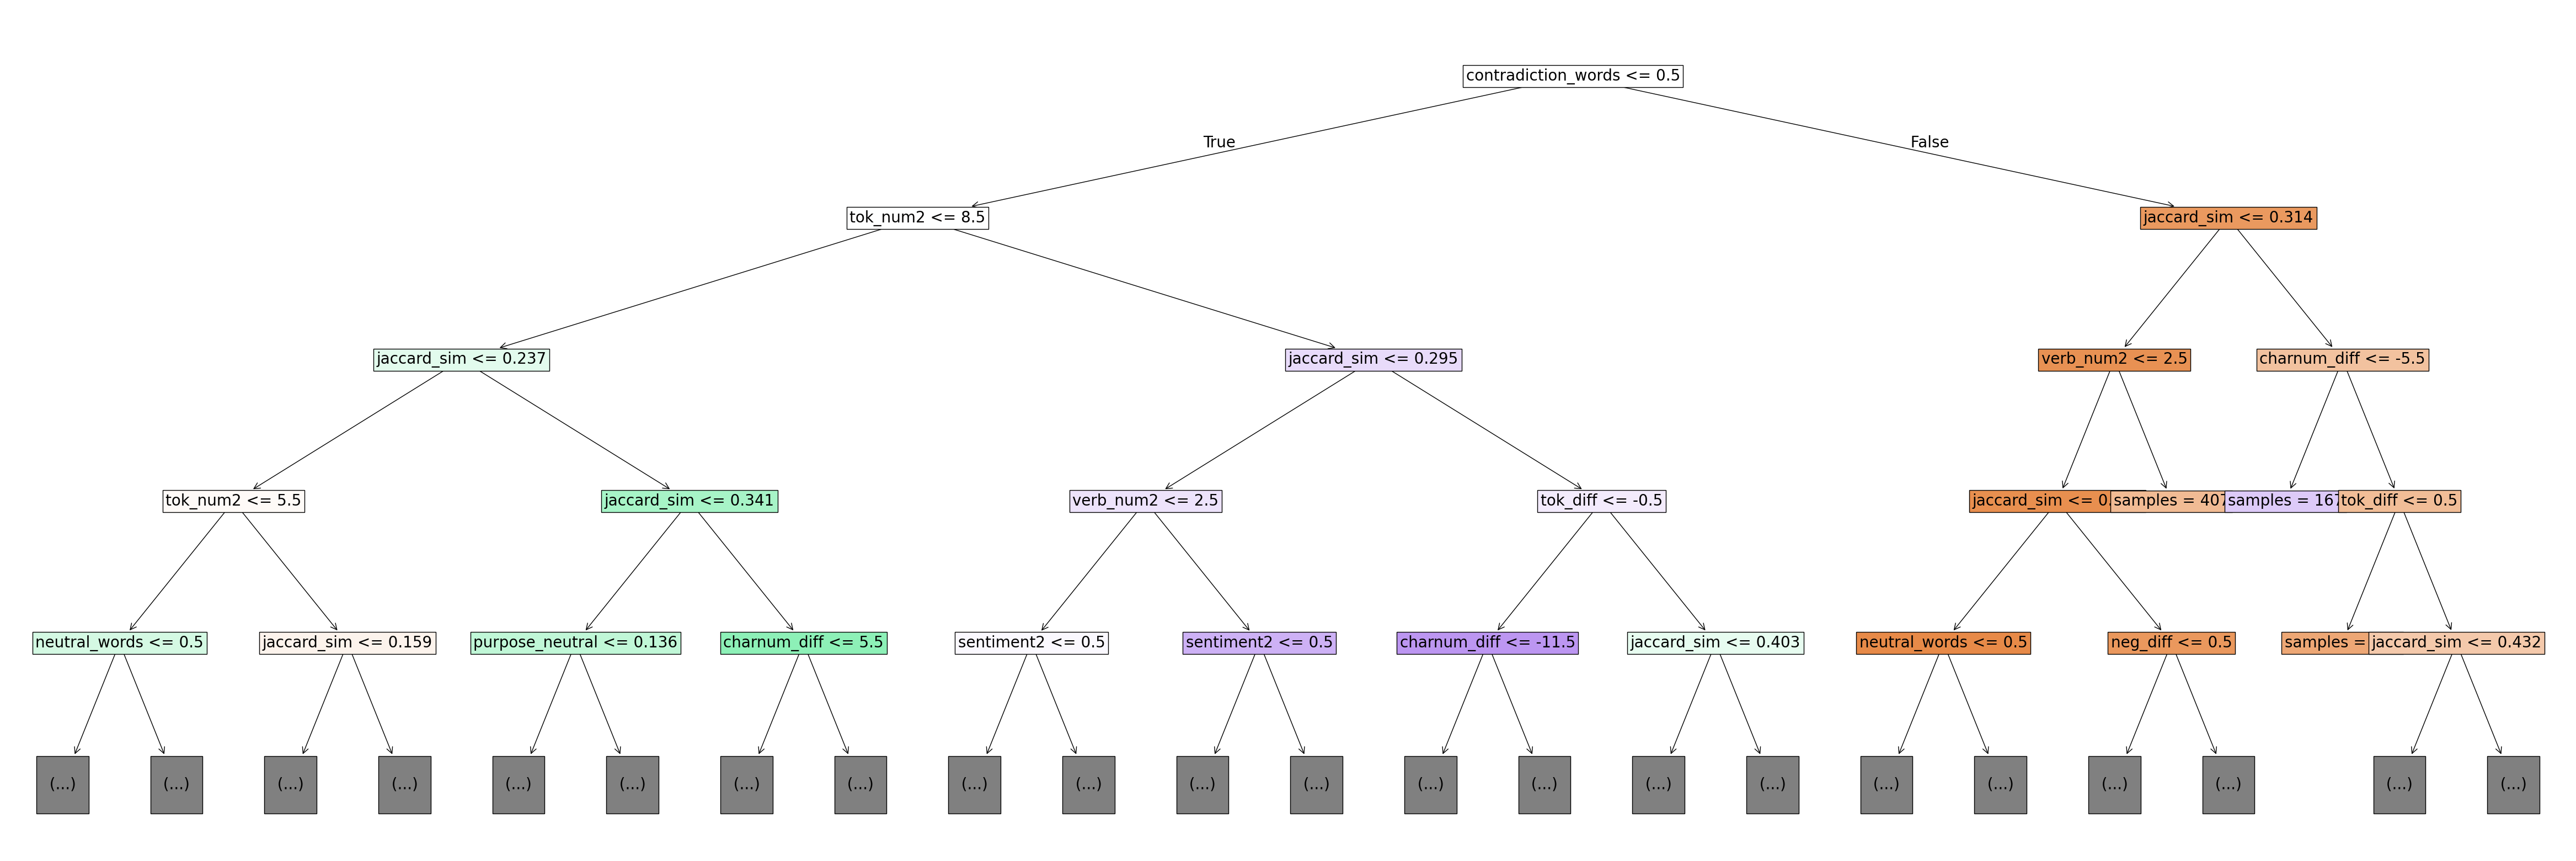

In [ ]:
# Displays tree with only the feature labels and threshold to make it more clear and interpretable
def custom_plot_tree(tree, feature_names):
    plt.figure(figsize=(60, 20))
    plot_tree(tree,
              filled=True,
              feature_names=feature_names,
              class_names=None,
              max_depth=4,
              fontsize=20,
              impurity=False,
              proportion=False)

    # Manually update text labels to only show feature & threshold
    for text in plt.gca().texts:
        txt = text.get_text()
        lines = txt.split("\n")

        # Extract only feature and threshold
        new_label = None
        for line in lines:
            if "<=" in line or 'samples' in line:
                new_label = line
                break

        if new_label:
            text.set_text(new_label)

    plt.show()


custom_plot_tree(optimal_DT, feat_df.columns)